In [178]:
from transformers import T5Tokenizer, T5Model, T5EncoderModel
import re
import time
import torch


tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_uniref50', do_lower_case=False)

model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.18.layer.0.SelfAttention.q.weight', 'decoder.block.17.layer.2.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.15.layer.0.SelfAttention.q.weight', 'decoder.block.19.layer.2.DenseReluDense.wi.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.13.layer.2.layer_norm.weight', 'decoder.block.20.layer.0.layer_norm.weight', 'decoder.block.20.layer.2.DenseReluDense.wi.weight', 'decoder.block.21.layer.0.SelfAttention.q.weight', 'decoder.block.15.layer.1.EncDecAttention.q.weight', 'decoder.block.15.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.16.layer.2.layer_norm.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.2.DenseReluDense.wo.weight', 'decoder.block.8.layer.1.EncDecAttention.q.weight', 'decoder.block.22.layer.0.SelfAt

In [184]:
import pandas as pd
import numpy as np

i_seq = 0
sequences = []
seq_df = pd.read_csv("data/genbank_spike_prot_clades.csv", sep=",")

seq_df = seq_df.sample(frac=1).reset_index(drop=True)
n_seqs = 10
batch_size = 10

for row in seq_df.iterrows():
    seq = row[1]["Sequence"]
    seq = re.sub("\*", "", seq)
    sequences.append(" ".join(seq))
    i_seq += 1
    if i_seq == n_seqs:
        break

In [180]:
len(sequences)

10

In [185]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
model = model.eval()

In [186]:
# map rarely occured amino acids (U,Z,O,B) to (X)
print("mapping to rare amino acids...")
#sequences = ["A E T C Z A O", "S K T Z P M V"]
sequences = [re.sub(r"[UZOJB]", "X", sequence) for sequence in sequences]
# Tokenize, encode sequences and load it into the GPU if possibile

print("tokenization...")
ids = tokenizer.batch_encode_plus(
    sequences, add_special_tokens=True, padding=True
)
input_ids = torch.tensor(ids["input_ids"]).to(device)
attention_mask = torch.tensor(ids["attention_mask"]).to(device)

input_ids.shape, attention_mask.shape

mapping to rare amino acids...
tokenization...


(torch.Size([10, 1274]), torch.Size([10, 1274]))

In [187]:
print("computing embedding...")

agg_embedding = list()
s_time = time.time()

for i in range(int(len(sequences) / batch_size)):
    curr = i * batch_size
    nex = i * batch_size + batch_size
    with torch.no_grad():
        embedding = model(input_ids=input_ids[curr:nex,], attention_mask=attention_mask[curr:nex,])
    embedding = embedding.last_hidden_state.cpu().numpy()
    agg_embedding.extend(embedding)
e_time = time.time()
print("embedding computed")
print("Time elapsed: {} minutes".format(str((e_time - s_time)/float(60))))

computing embedding...
embedding computed
Time elapsed: 0.28317283391952514 minutes


In [183]:
agg_embedding = np.array(agg_embedding)
agg_embedding.shape

(10, 1274, 1024)

In [131]:
def save_embedding():
    import h5py
    hf = h5py.File('data/save_agg_embedding_{}.h5'.format(str(len(sequences))), 'w')
    hf.create_dataset('embedding', data=agg_embedding)
    hf.close()
save_embedding()

In [121]:
import numpy as np
features = []
agg_features = []
for seq_num in range(len(agg_embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = agg_embedding[seq_num][: seq_len - 1]
    agg_features.append(np.mean(seq_emd, axis=0))
    features.append(seq_emd)

In [122]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

X = np.array(agg_features)
X.shape

(500, 1024)

['20A', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '20A', '21K (Omicron)', '21K (Omicron)', '21L (Omicron)', '21K (Omicron)', '21K (Omicron)', '20C', '20C', '20C', '20G', '21K (Omicron)', '21K (Omicron)', '21L (Omicron)', '21K (Omicron)', '20C', '21K (Omicron)', '21J (Delta)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '20C', '20C', '20C', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '20C', '21K (Omicron)', '21I (Delta)', '21J (Delta)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '20C', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '20A', '21K (Omicron)', '21L (Omicron)', '21J (Delta)', '21L (Omicron)', '21K (Omicron)', '21L (Omicron)', '21K (Omicron)', '21K (Omicron)', '20A', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '20B', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '21K (Omicron)', '20A', '21K (Omicr

<ipython-input-172-5ea5ee5a9730>:27: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=new_hue_list, palette=sns.color_palette("hls", n_colors), data=df).set(title="T-SNE projection")


[Text(0.5, 1.0, 'T-SNE projection')]

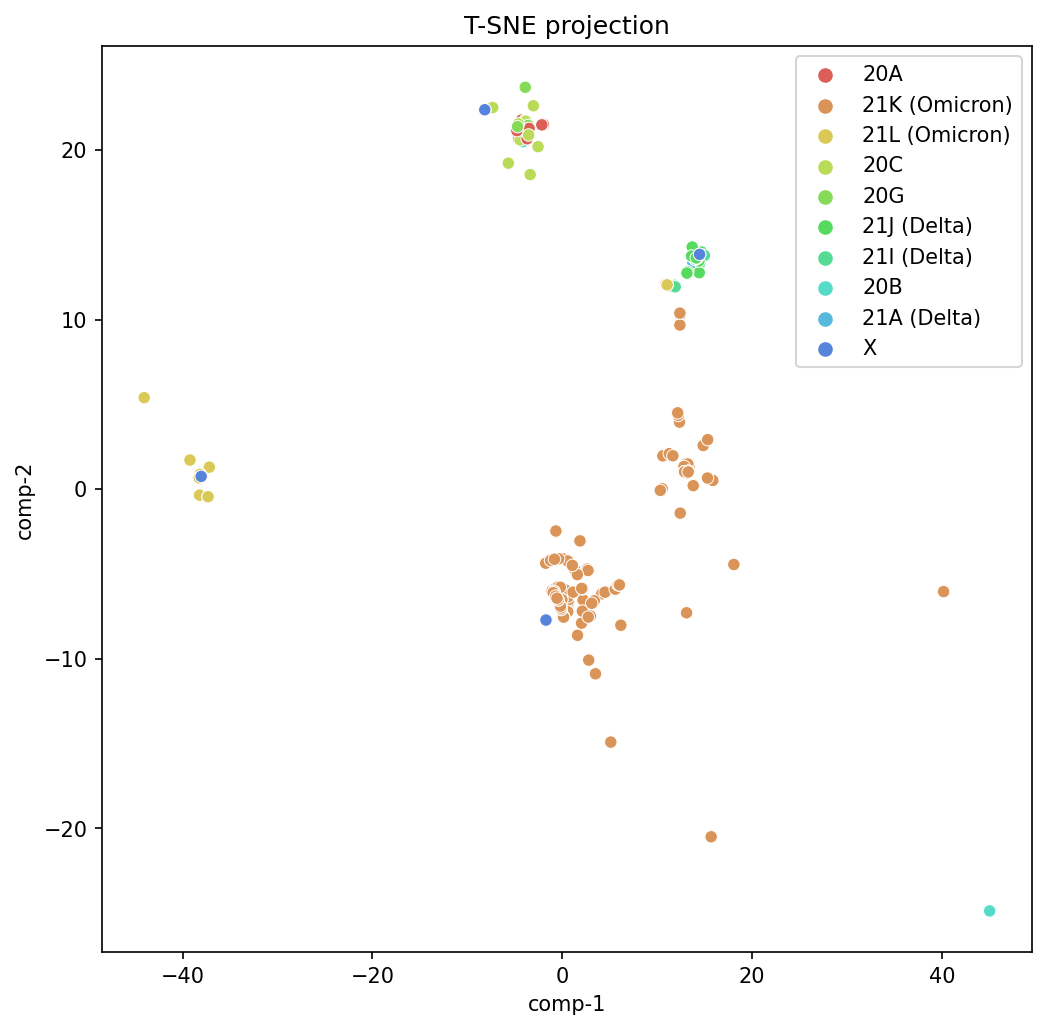

In [172]:
from matplotlib.pyplot import figure

perplexity = 30
n_colors = 15
figsize = (8, 8)

figure(figsize=figsize, dpi=150)

z = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X)

df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

hue_list = seq_df["Clade"].tolist()[:n_seqs]

print(hue_list)

new_hue_list = hue_list

new_hue_list[-5:] = ['X', 'X', 'X', 'X', 'X'] 
# 20C','21L (Omicron)','21K (Omicron)','21J (Delta)','21K (Omicron)'

print()

sns.scatterplot(x="comp-1", y="comp-2", hue=new_hue_list, palette=sns.color_palette("hls", n_colors), data=df).set(title="T-SNE projection")

In [173]:
#'20C', '21L (Omicron)', '21K (Omicron)', '21J (Delta)', '21K (Omicron)'

<ipython-input-177-25f7f8a0f8a2>:21: UserWarning: The palette list has more values (15) than needed (10), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=new_hue_list, palette=sns.color_palette("hls", n_colors), data=df_umap).set(title="UMAP projection")


[Text(0.5, 1.0, 'UMAP projection')]

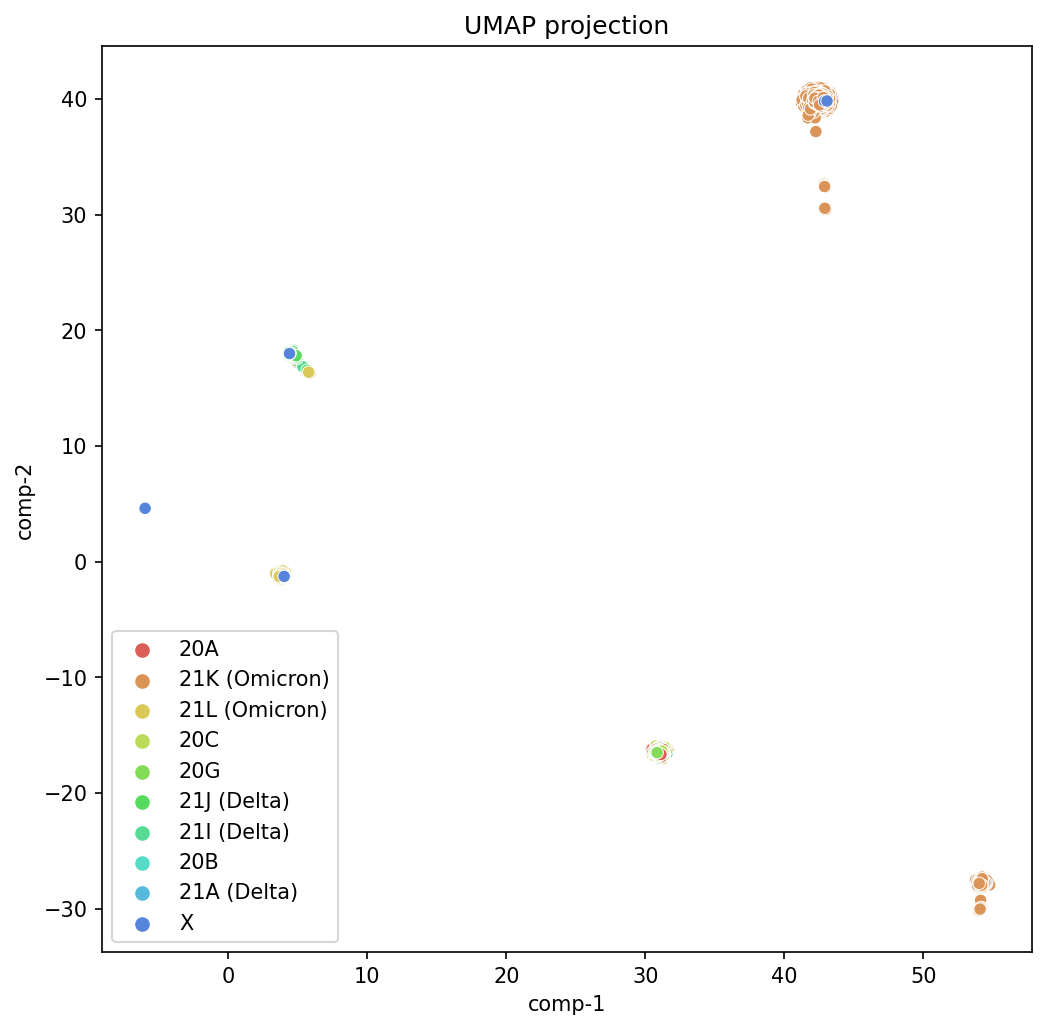

In [177]:
from umap import UMAP

figure(figsize=figsize, dpi=150)

n_colors = 15
#n_neighbors=15
#min_dist=0.01
n_components=2
metric='euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors=50, min_dist=0.1, metric=metric, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X)

df_umap = pd.DataFrame()
df_umap["comp-1"] = proj_2d[:,0]
df_umap["comp-2"] = proj_2d[:,1]

#new_hue_list = seq_df["Clade"].tolist()[:n_seqs]

sns.scatterplot(x="comp-1", y="comp-2", hue=new_hue_list, palette=sns.color_palette("hls", n_colors), data=df_umap).set(title="UMAP projection")